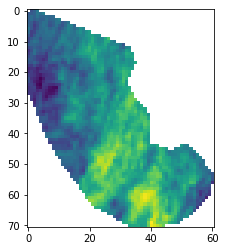

[[       nan -31.866587 -30.766207 ...        nan        nan        nan]
 [-31.294182 -31.216831 -30.700855 ...        nan        nan        nan]
 [-30.715887 -29.759354 -30.611557 ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


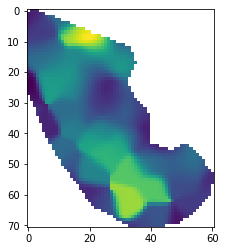

[[       nan 0.1718651  0.19427955 ...        nan        nan        nan]
 [0.1482669  0.16936696 0.19022663 ...        nan        nan        nan]
 [0.15320674 0.17677967 0.20075893 ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


In [1]:
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib as plt

# takes in igram.tif that has been warped to v_m map using warptool, use qgis to mask
with rasterio.open('igram.tif') as src1:
    igram = src1.read(1)
igram[igram==0] = np.nan

with rasterio.open('v_m.tif') as src2:
    v_m_guess = src2.read(1)
v_m_guess[v_m_guess<0] = np.nan

show(igram)
print(igram)
show(v_m_guess)
print(v_m_guess)


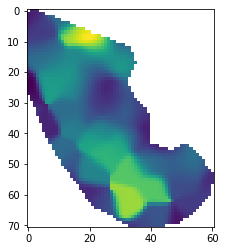

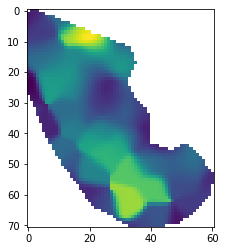

<AxesSubplot:>

In [2]:
slope = 11
incidence = 37
show(v_m_guess)
v_m_LOS = (v_m_guess*np.cos(np.deg2rad((90-incidence)+slope)))
show(v_m_LOS)


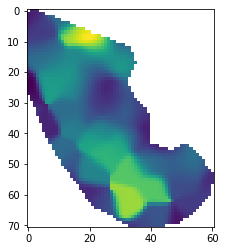

[[      nan 2.261894  2.5568874 ...       nan       nan       nan]
 [1.9513209 2.229016  2.5035474 ...       nan       nan       nan]
 [2.0163336 2.3265736 2.6421616 ...       nan       nan       nan]
 ...
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]]


In [3]:
wavelength = 0.055
t_years = 0.1314
phase_contribution_due_to_v_in_LOS = (((4*np.pi)/wavelength)*v_m_LOS*t_years)
show(phase_contribution_due_to_v_in_LOS)
print(phase_contribution_due_to_v_in_LOS)

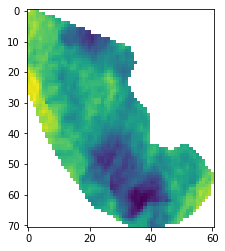

[[      nan 29.604692 28.20932  ...       nan       nan       nan]
 [29.342861 28.987816 28.197308 ...       nan       nan       nan]
 [28.699554 27.43278  27.969395 ...       nan       nan       nan]
 ...
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]]


In [4]:
phase_contribution_due_to_snow = abs(igram)-abs(phase_contribution_due_to_v_in_LOS)
show(phase_contribution_due_to_snow)
print(phase_contribution_due_to_snow)

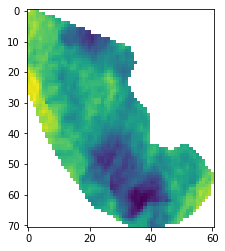

<AxesSubplot:>

In [5]:
delta_swe = (wavelength/(2*np.pi))*((phase_contribution_due_to_snow)/(1+(1.59+np.deg2rad(37)**(5/2))))
show(delta_swe)

In [6]:
print(delta_swe)

[[       nan 0.08859313 0.08441742 ...        nan        nan        nan]
 [0.08780958 0.08674709 0.08438147 ...        nan        nan        nan]
 [0.08588446 0.08209359 0.08369943 ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


In [7]:
# Register GDAL format drivers and configuration options with a
# context manager.
newsrc = rasterio.open("igram.tif")
with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = newsrc.profile

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(
        dtype=rasterio.float32,
        count=1,
        compress='lzw')

    with rasterio.open('delta_swe_map.tif', 'w', **profile) as dst:
        dst.write(delta_swe.astype(rasterio.float32),1)

# At the end of the ``with rasterio.Env()`` block, context
# manager exits and all drivers are de-registered.